Epoch 1/100


c:\Users\mehdi\OmniFold\my_env\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9400/9400 ━━━━━━━━━━━━━━━━━━━━ 10s 912us/step - accuracy: 0.4997 - loss: 0.4073
Epoch 2/100
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 9s 907us/step - accuracy: 0.4989 - loss: 0.4081
Epoch 3/100
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 9s 914us/step - accuracy: 0.5001 - loss: 0.4070
Epoch 4/100
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 9s 921us/step - accuracy: 0.4990 - loss: 0.4077
Epoch 5/100
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.5007 - loss: 0.4075
Epoch 6/100
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.4999 - loss: 0.4072
Epoch 7/100
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.4999 - loss: 0.4076
Epoch 8/100
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.5009 - loss: 0.4062
Epoch 9/100
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5008 - loss: 0.4057
Epoch 10/100
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.5006 - loss: 0.4068
Epoch 11/100
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.4997 - loss: 0.4073
Epoch 12/100
940

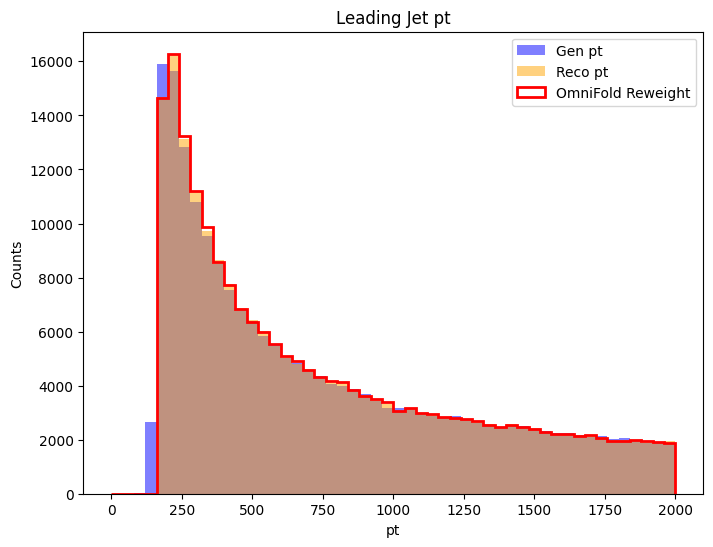

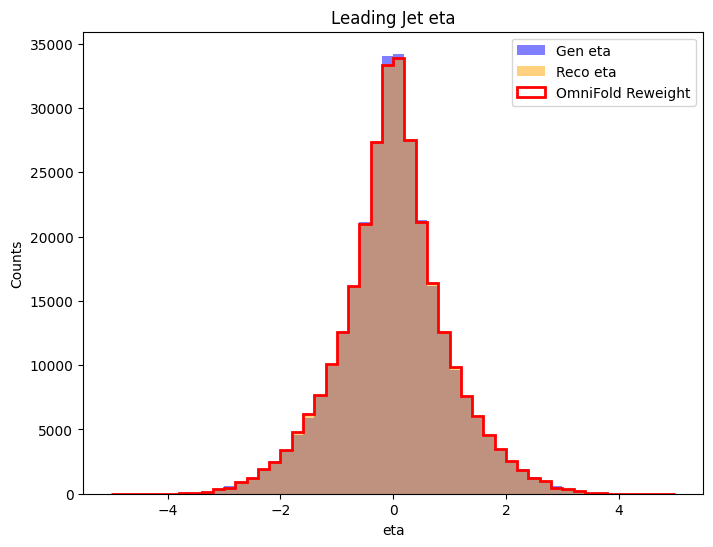

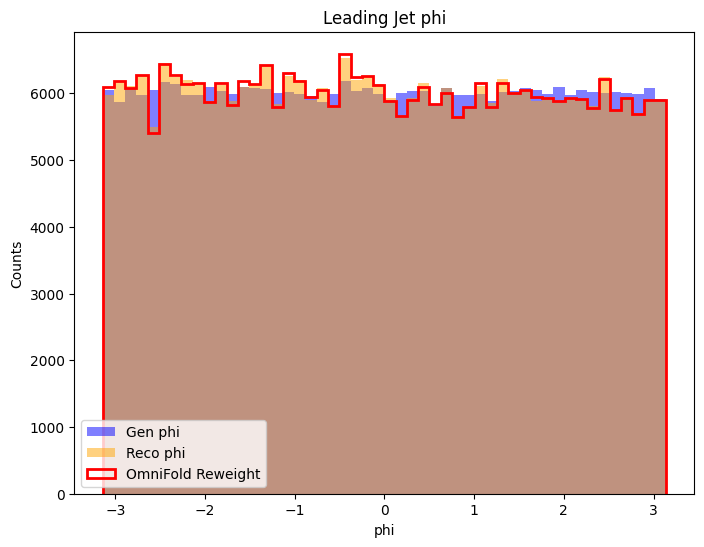

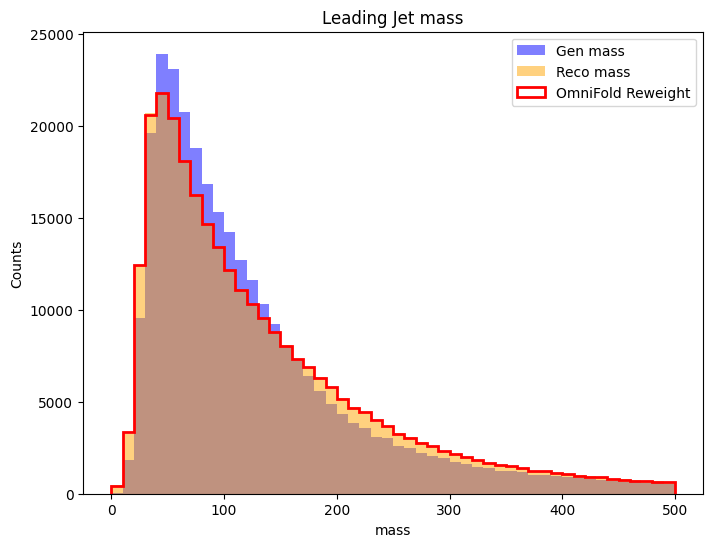

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the binary crossentropy 
def binary_crossentropy_from_logits(y_true, y_pred):
    return tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, labels=y_true, pos_weight=1))

# Define the model architecture and compilation
def build_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.1),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss=binary_crossentropy_from_logits, metrics=['accuracy'])
    return model

# Define the OmniFold method
def omnifold(theta0, theta_unknown_S, iterations, model, verbose):
    labels = np.random.randint(0, 2, size=(len(theta0), 1))  # Binary labels
    weights = np.random.rand(len(theta0))  # Sample weights
    model.fit(theta0, labels, sample_weight=weights, epochs=100, verbose=verbose)
    return np.random.rand(len(theta0))

# Load data from ROOT file
qcd_mc = uproot.open('Data2.root')['Events']

# Extract reco and gen jet data
fields = ['pt', 'eta', 'phi', 'mass']
jet_reco = {f: qcd_mc[f'FatJet_{f}'].array()[:, :1] for f in fields}
jet_gen = {f: qcd_mc[f'GenJetAK8_{f}'].array()[:, :1] for f in fields}

# Mask to filter valid events
mask = (ak.num(jet_reco['pt'], axis=1) > 0) & (ak.num(jet_gen['pt'], axis=1) > 0)
for f in fields:
    jet_reco[f] = jet_reco[f][mask]
    jet_gen[f] = jet_gen[f][mask]

# Prepare data for OmniFold reweighting
theta0 = np.stack([ak.to_numpy(jet_gen['pt']), ak.to_numpy(jet_gen['eta'])], axis=1)
theta_unknown_S = np.stack([ak.to_numpy(jet_reco['pt']), ak.to_numpy(jet_reco['eta'])], axis=1)

# Initialize and compile the model for OmniFold
input_dim = theta0.shape[1]
model = build_model(input_dim)

# Run OmniFold and obtain the weights
weights = omnifold(theta0, theta_unknown_S, iterations=10, model=model, verbose=1)

# Normalize the weights
normalized_weights = weights / np.sum(weights) * len(weights)

# Define bins for histograms
bin_settings = {
    'pt': np.linspace(0, 2000, 51),
    'eta': np.linspace(-5, 5, 51),
    'phi': np.linspace(-np.pi, np.pi, 51),
    'mass': np.linspace(0, 500, 51),
}

# Plotting histograms individually
for prop in fields:
    plt.figure(figsize=(8, 6))
    bins = bin_settings[prop]
    gen_data = ak.to_numpy(ak.flatten(jet_gen[prop]))
    reco_data = ak.to_numpy(ak.flatten(jet_reco[prop]))
    plt.hist(gen_data, bins=bins, alpha=0.5, label=f'Gen {prop}', color='blue')
    plt.hist(reco_data, bins=bins, alpha=0.5, label=f'Reco {prop}', color='orange')
    plt.hist(reco_data, bins=bins, weights=normalized_weights, histtype='step', label='OmniFold Reweight', color='red', linewidth=2)
    plt.title(f'Leading Jet {prop}')
    plt.xlabel(prop)
    plt.ylabel('Counts')
    plt.legend()
    plt.show()

    
